# Notebook for non-kernal models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, make_scorer, fbeta_score

from scripts.nested_CV import nested_cv

In [ ]:
# configs
seed = 42  # for repeatability

fbeta_scorer = make_scorer(fbeta_score, beta=2, pos_label=-1)

### Data import and preprocessing

In [13]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)

print(X.shape, y.shape)

(200, 60) (200,)


In [14]:
# normalizing the data and splitting into train/test splits
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

## Baseline 1: Linear Classification - No regularization (Ordinary Least squares)

### Tuning and Evaluation

There are no hyperparameters to tune here. To evaluate the model, we just use plain simple cross valdiation (Kfold) to estimate the accuracy and more importantly the recall of the negative class 

In [15]:
clf_ols = LinearRegression()
clf_ols.fit(X_train, y_train)
y_pred = clf_ols.predict(X_test)
y_class = np.where(y_pred >= 0, 1, -1)
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

          -1       0.80      0.94      0.86        17
           1       0.95      0.83      0.88        23

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40



In [16]:
scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
print(scores.mean())

-0.5144542261404567


## Basline 2: Logistic Regression

### Tuning
We tune for the recall of the negative class, under the assumption that shipping a medical grade laser is more expensive than re-testing and/or repairing it. Therefore, it's better to identify as many faulty lasers as possible, even if it means re-testing some positive ones. 

Here we tune the hyper-parameters to get the best possible desired performance metric for our classifier. Explanation of Tuning and Evaluation is provided here, with the aid of visualization, but for the rest of the models a nested cross validation function is directly called (`src/scripts/nested_CV.py`), which utilizes grid search to tune multiple hyperparameters at once. Furthermore it provides the advantage of being more practical.

The nested cross validation function is used here as well, but also visual explanataions are provided

#### Nested Cross Validation

In [17]:
param_grid_log = {
    'C' : np.logspace(-3,3,7)
}
results = nested_cv(LogisticRegression(penalty='l2'), X, y, param_grid=param_grid_log, scoring=fbeta_scorer, random_state=seed)

print(">>>>RESULTS<<<<")
print("Mean f2 score (of negative class) over 5 by 5 rounds of Nested CV ", results["mean_score"])
print("Best parameters ", results["star_params"])

>>>>RESULTS<<<<
Mean f2 score (of negative class) over 5 by 5 rounds of Nested CV  0.9193507586052723
Best parameters  {'C': 0.1}


In [ ]:
clf_log = LogisticRegression(C=.1)
clf_log.fit(X, y)

y_pred_log = clf_log.predict(X)
print(classification_report(y, y_pred_log))

              precision    recall  f1-score   support

          -1       0.99      0.96      0.97       100
           1       0.96      0.99      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



## BUT ..... 

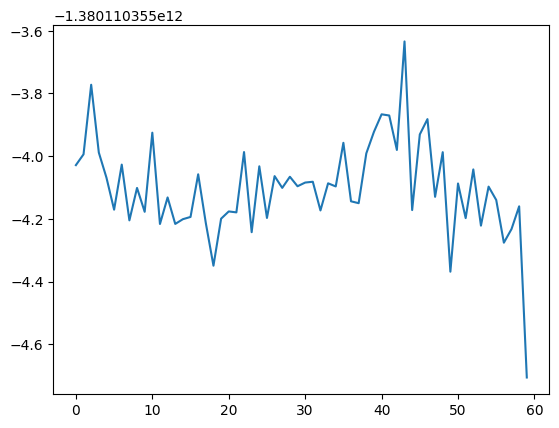

In [19]:
plt.plot(clf_ols.coef_)

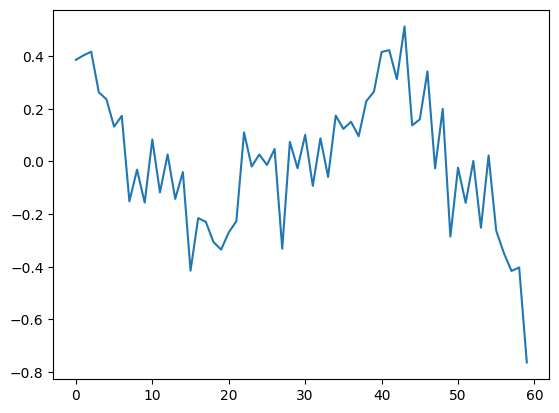

In [20]:
plt.plot(clf_log.coef_[0])